### Project 1 - CS205

Board states are represented as 2-D lists, where the blank slot is represented by 0 and the puzzle is read left to right, top to bottom. For example, the solved Angelica puzzle will be represented as [['A','N','G'],['E','L','I'],['C','A',' ']].

Our state, (Node) contains 4 instance variables:
- **board** - a board represented as a list shown above
- **prev_board** - its parent state which is also represented as a list
- **g** and **h** - a pair of integers which correspond to the g(n) and h(n) values discussed in class

There are three accessor methods: 
- **get_board()** - returns the Node's board state
- **get_prev()** - returns the stored parent board state
- **get_g()** - which returns the stored value of g(n)

In [2]:
class Node:
    def __init__(self, board, prev_board, g, h):
        self.board = board
        self.prev_board = prev_board
        self.g = g
        self.h = h

    def get_board(self):
        return self.board
    
    def get_prev_board(self):
        return self.prev_board

    def get_g(self):
        return self.g

There is no accessor for h. Instead, we will use the helper function get_h() to calculate the heuristic of a state using the manhattan distance. To calculate the manhattan distances, the function references a lookup table holding the correct positions of each letter. Note that for 'A', we add the manhattan distance of the closer correct 'A' spot.

In [3]:
solved = {'N':(0,1),'G':(0,2),'E':(1,0),'L':(1,1),'I':(1,2),'C':(2,0)}

def manhat(start, end):
  return abs(start[0]-end[0]) + abs(start[1]-end[1])

def get_h(board):
    h = 0
    for r, row in enumerate(board):
        for c, val in enumerate(row):
            if val != ' ':
                if val == 'A':
                    h1 = manhat((r,c), (0,0))
                    h2 = manhat((r,c),(2,1))
                    h += min(h1,h2)
                else:
                    h += manhat((r,c),solved[val])
    return h

The swap function will return a shallow copy of the input board with the values at (r1,c1) and (r2,c2) swapped. This helper function will be used to expand board states by moving the blank up, down, left, and right.

In [4]:
def swap(board, r1, c1, r2, c2):
    temp = [row[:] for row in board]
    temp[r1][c1], temp[r2][c2] = temp[r2][c2], temp[r1][c1]
    return temp

The expand() function takes a Node (n), the priority queue it adds new Nodes to (q), an interator (counter).

The function locates the position of the blank tile, determines the possible new states to add
to the priority queue, and adds them accordingly with the g and h values.

In [5]:
def expand(n, q, counter):
    new_g = n.get_g() + 1
    
    # Finding index of blank tile
    for i, x in enumerate(n.get_board()):
        if ' ' in x:
            blank_r = i
            blank_c = x.index(' ')
    
    # Can only move blank up if it is on row 1 or 2 
    if blank_r > 0:
        new_board1 = swap(n.get_board(), blank_r, blank_c, blank_r-1, blank_c)
        new_h1 = get_h(new_board1)
        q.put((new_g + new_h1, next(counter), Node(new_board1, n.get_board(), new_g, new_h1)))
        
    # Can only move blank down if it is on row 0 or 1
    if blank_r < 2:
        new_board2 = swap(n.get_board(), blank_r, blank_c, blank_r+1, blank_c)
        new_h2 = get_h(new_board2)
        q.put((new_g + new_h2, next(counter), Node(new_board2, n.get_board(), new_g, new_h2)))
        
    # Can only move blank left if is is on column 1 or 2
    if blank_c > 0:
        new_board3 = swap(n.get_board(), blank_r, blank_c, blank_r, blank_c-1)
        new_h3 = get_h(new_board3)
        q.put((new_g + new_h3, next(counter), Node(new_board3, n.get_board(), new_g, new_h3)))
        
    #  Can only move blank right if it is on column 0 or 1
    if blank_c < 2:
        new_board4 = swap(n.get_board(), blank_r, blank_c, blank_r, blank_c+1)
        new_h4 = get_h(new_board4)
        q.put((new_g + new_h4, next(counter), Node(new_board4, n.get_board(), new_g, new_h4)))

The repeated() function takes a list (board) and checks it against a list of boards (_list). repeated() returns true if the list
contains the board and false if the list does not. This function is used to check for repeated board states.

The print_board() function will print a board with each row on a new line. It will also adjust the hardcoded second 'A' as 'B' to an 'A' in the system output.

In [6]:
def repeated(board, _list):
    for i in _list:
        if board == i:
            return True
    return False

def print_board(board):
    for row in board:
        space = ''
        for value in row:
            print(space + value, end='')
            space = ' '
        print()

The search function takes an initial board (init_board) and a trace flag represented as a char (trace) and performs A* search for the goal state using manhattan distance. If the goal state is found, a success message is displayed along with the depth, expanded nodes, frontier nodes, and the time taken. If no goal state is found, a failure message is displayed along with the expanded nodes and time taken. If the trace flag is '1', the trace for the solution is displayed as well.

In [7]:
from queue import PriorityQueue
import itertools
import time

def search(init_board, trace):
    start_time = time.time()
    expanded_nodes = 0
    frontier_nodes = 0

    # This iterator from python's itertools library is used to assign a unique value to each tuple, as python's priority queue compares subsequent values 
    # in tuples when prior values are equal, but I did not want to overload the '<' operator for my defined Node class. Since we can choose how to prioritize
    # Nodes with the same priority, this method is used.
    counter = itertools.count()
    repeated_states = []
    max_q_size = 0
    print('Using initial board:')
    print_board(init_board)

    # initial node creation
    n = Node(init_board, init_board, 0, get_h(init_board))
    q = PriorityQueue()

    # This is how we assign unique integers to the tuple's second value.
    q.put((n.get_g(), next(counter), n))
    
    while not q.empty():
        # update the max queue size accordingly
        if(q.qsize()>max_q_size):
            max_q_size = q.qsize()

        # we dequeue the first board from our priority queue and set it equal to temp
        temp = q.get()[2]
        # we skip the expansion process if the board is repeated.
        if(repeated(temp.get_board(),repeated_states)):
            continue

        # success state, all displayed values are appropriately calculated
        if(temp.get_board() == [['A','N','G'],['E','L','I'],['C','A',' ']]):
            print('Final board:')
            print_board(temp.get_board())
            print('Success!')
            print('Depth: ' + str(temp.get_g()))
            print('Expanded Nodes: ' + str(expanded_nodes))
            print('Frontier Nodes: ' + str(q.qsize()))
            print('Max Queue Size: '+ str(max_q_size))
            print("-- %s seconds -- were used." % round((time.time() - start_time),2))
            return

        # trace check whether to output trace of expansion or not
        if(trace == '1'):
            print('The next state to expand has g(n) = ' + str(temp.get_g()) + ' and h(n) = ' + str(get_h(temp.get_board())) + ':')
            print_board(temp.get_board())

        # expansion of dequeued node
        expand(temp, q, counter)

        # add this expanded node to repeated_states[]
        repeated_states.append(temp.get_board())
        expanded_nodes += 1
    
    # failure state, our priority queue has nothing left to check
    print('No solution exists!')
    print('Expanded Nodes: ' + str(expanded_nodes))
    print("-- %s seconds -- were used." % round((time.time() - start_time),2))

Main function that will attempt to solve a default angelica puzzle or a user inputted angelica puzzle. The format for inputting a custom board is from left to right, top to bottom, with 'B' as blank tile and including spaces in between tiles. A trace of the search can be included if '1' is entered.

In [51]:
def angelica():
    num = input('Type "1" to use a default puzzle or "2" to enter your own puzzle.\n')
    if(num == '1'):
        init_board = [[' ','C','N'],['E','I','A'],['G','L','A']]
    if(num == '2'):
        my_string = input('Enter a puzzle from left to right, top to bottom, using \'B\' for the blank tile and including spaces in between tiles. Ex: "A N G E L I C A B".\n')
        my_list = my_string.split()      
        temp = [x if x != 'B' else ' ' for x in list(my_list)]
        init_board = [temp[:3],temp[3:6],temp[6:]]
    trace = input('Would you like to display a trace of the algorithm? "1" for YES and "2" for NO\n')
    search(init_board, trace)

angelica()

Type "1" to use a default puzzle or "2" to enter your own puzzle.
2
Enter a puzzle from left to right, top to bottom, using 'B' for the blank tile and including spaces in between tiles. Ex: "A N G E L I C A B".
C A N E A L I G B
Would you like to display a trace of the algorithm? "1" for YES and "2" for NO
1
Using initial board:
C A N
E A L
I G  
The next state to expand has g(n) = 0 and h(n) = 12:
C A N
E A L
I G  
The next state to expand has g(n) = 1 and h(n) = 11:
C A N
E A L
I   G
The next state to expand has g(n) = 2 and h(n) = 10:
C A N
E   L
I A G
The next state to expand has g(n) = 2 and h(n) = 10:
C A N
E A L
  I G
The next state to expand has g(n) = 3 and h(n) = 9:
C A N
E L  
I A G
The next state to expand has g(n) = 4 and h(n) = 8:
C A N
E L G
I A  
The next state to expand has g(n) = 3 and h(n) = 10:
C   N
E A L
I A G
The next state to expand has g(n) = 4 and h(n) = 9:
C N  
E A L
I A G
The next state to expand has g(n) = 1 and h(n) = 13:
C A N
E A  
I G L
The next state 

The next state to expand has g(n) = 11 and h(n) = 8:
A N A
C I G
E   L
The next state to expand has g(n) = 10 and h(n) = 9:
E N  
I C L
A A G
The next state to expand has g(n) = 10 and h(n) = 9:
  C N
E I L
A A G
The next state to expand has g(n) = 10 and h(n) = 9:
E C N
I L G
A A  
The next state to expand has g(n) = 12 and h(n) = 7:
A A N
E L G
I C  
The next state to expand has g(n) = 15 and h(n) = 4:
A N G
A L  
C E I
The next state to expand has g(n) = 13 and h(n) = 6:
C N G
E L  
I A A
The next state to expand has g(n) = 7 and h(n) = 12:
C A A
E N L
I   G
The next state to expand has g(n) = 11 and h(n) = 8:
A C N
A L G
E   I
The next state to expand has g(n) = 13 and h(n) = 6:
A E N
A L G
C   I
The next state to expand has g(n) = 10 and h(n) = 9:
A N A
C E L
  I G
The next state to expand has g(n) = 12 and h(n) = 7:
A N A
C I G
E L  
The next state to expand has g(n) = 11 and h(n) = 8:
C   N
E I L
A A G
The next state to expand has g(n) = 16 and h(n) = 3:
A N G
A L I
C E  
The ne

A N G
E L I
C A  
Success!
Depth: 20
Expanded Nodes: 585
Frontier Nodes: 637
Max Queue Size: 638
-- 0.38 seconds -- were used.


In [35]:
import matplotlib as plt
import pandas as pd

df = pd.read_csv('table_data.csv')
df.head()

,Depth,Expanded Nodes,Frontier Nodes,Max Queue Size
0,0,0,0,1
1,2,2,3,4
2,4,4,8,9
3,8,12,22,23
4,12,36,49,50


<AxesSubplot:title={'center':'Space Complexity vs. Depth'}, xlabel='Depth', ylabel='Nodes'>

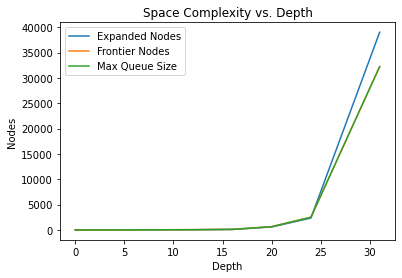

In [45]:
df.plot(x='Depth',title='Space Complexity vs. Depth',ylabel='Nodes')

<AxesSubplot:title={'center':'Logarithmically Scaled Space Complexity vs. Depth'}, xlabel='Depth', ylabel='Nodes'>

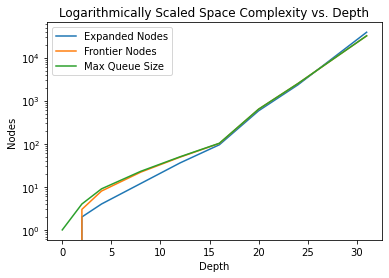

In [46]:
df.plot(x='Depth', logy=True, title='Logarithmically Scaled Space Complexity vs. Depth',ylabel='Nodes')